## Import packages

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

In [2]:
import os
os.environ["PATH"] += os.pathsep + 'C:/Program Files (x86)/Graphviz2.38/bin/'  # 安装graphviz的路径，用于模型可视化

In [ ]:
from keras.preprocessing.text import Tokenizer, text_to_word_sequence
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential, Model
from keras.layers.core import Dense, Activation, Dropout
from keras.layers.embeddings import Embedding
from keras.layers.recurrent import LSTM, GRU
from keras.layers.normalization import BatchNormalization
from keras.layers.merge import concatenate
from keras.layers import TimeDistributed, Lambda, Input, SpatialDropout1D
from keras.layers import Conv1D, GlobalMaxPooling1D
from keras.callbacks import ModelCheckpoint
from keras import backend as K
from keras.layers.advanced_activations import PReLU
from keras.preprocessing import sequence, text
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from keras.utils import plot_model
from keras import optimizers
from sklearn.model_selection import train_test_split
from sklearn.metrics import log_loss

Using TensorFlow backend.


## Hyper parameter setting

In [5]:
token = 'words' # based on words or chars
embed_size = 300 # how big is each word vector
max_features = 20890 # how many unique words to use (i.e num rows in embedding vector)
maxlen = 40 # max number of words in a comment to use
num_rnn_units = 128
num_hidden_units = 200
drop_prob = 0.2
max_norm = 5.0
nb_filter = 64
filter_length = 5

## File path

In [6]:
TRAIN_PATH = './train.csv'
TEST_PATH = './test.csv'
QUESTION_PATH = './question.csv'
embed_files = {'words': './word_embed.txt', 'chars': './char_embed.txt'}

## Some helper function

In [7]:
# Get question id from a list. Remove the Q
def get_ids(qids):
    ids = []
    for t_ in qids:
        ids.append(int(t_[1:]))
    return np.asarray(ids)

# Get the text
def get_texts(q_list, question_path=QUESTION_PATH):
    qes = pd.read_csv(question_path)
    ids = get_ids(q_list)
    all_tokens = qes[token]
    texts = [all_tokens[t] for t in ids]
    return texts

## Read the text

#### Train data
split some data for validation

In [8]:
train = pd.read_csv(TRAIN_PATH)
list_train = list(zip(train['q1'], train['q2']))
label_train = train['label']
#print(len(list_train), len(label_train))

X_tra, X_val, y_tra, y_val = train_test_split(list_train, label_train, train_size=0.85, random_state=8, shuffle=True)

# get the text list of question 1 and 2
q1_train = [i[0] for i in X_tra]
text1_train = get_texts(q1_train)
q2_train = [i[1] for i in X_tra]
text2_train = get_texts(q2_train)
q1_val = [i[0] for i in X_val]
text1_val = get_texts(q1_val)
q2_val = [i[1] for i in X_val]
text2_val = get_texts(q2_val)

C:\Users\SJ\AppData\Local\conda\conda\envs\deep\lib\site-packages\sklearn\model_selection\_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


#### Test data

In [9]:
test = pd.read_csv(TEST_PATH)
list_test = list(zip(test['q1'], test['q2']))

# get the text list of question 1 and 2
q1_test = [i[0] for i in list_test]
text1_test = get_texts(q1_test)
q2_test = [i[1] for i in list_test]
text2_test = get_texts(q2_test)

## Tokenize

In [10]:
tokenizer = Tokenizer(num_words=max_features, lower=False) # Don't lower the W or L!!!
tokenizer.fit_on_texts(pd.read_csv(QUESTION_PATH)[token])

# train set
tokenized1_train = tokenizer.texts_to_sequences(text1_train)
tokenized2_train = tokenizer.texts_to_sequences(text2_train)
X1_train = pad_sequences(tokenized1_train, maxlen=maxlen)
X2_train = pad_sequences(tokenized2_train, maxlen=maxlen)

# validation set
tokenized1_val = tokenizer.texts_to_sequences(text1_val)
tokenized2_val = tokenizer.texts_to_sequences(text2_val)
X1_val = pad_sequences(tokenized1_val, maxlen=maxlen)
X2_val = pad_sequences(tokenized2_val, maxlen=maxlen)

# test set
tokenized1_test = tokenizer.texts_to_sequences(text1_test)
tokenized2_test = tokenizer.texts_to_sequences(text2_test)
X1_test = pad_sequences(tokenized1_test, maxlen=maxlen)
X2_test = pad_sequences(tokenized2_test, maxlen=maxlen)

## Prepare the pretrained word embedding

In [11]:
def get_coefs(line): return line[0], np.asarray(line[1:], dtype='float32')
embed_file = embed_files[token]
embeddings_index = dict(get_coefs(o.strip().split()) for o in open(embed_file, encoding='utf-8'))
print (len(embeddings_index.items()))
#print (list(embeddings_index.items())[20890])

20891


In [12]:
all_embs = np.hstack(embeddings_index.values())
emb_mean,emb_std = all_embs.mean(), all_embs.std()
emb_mean,emb_std

(0.015683081, 1.1956546)

In [13]:
word_index = tokenizer.word_index
embedding_matrix = np.random.normal(emb_mean, emb_std, (max_features+1, embed_size))

for word, i in word_index.items():
    if i > max_features: break
    embedding_vector = embeddings_index.get(word)
    #print (i, word, len(embedding_vector))
    if embedding_vector is not None: embedding_matrix[i] = embedding_vector

In [14]:
embedding_matrix = np.asarray(embedding_matrix, dtype='float32')

## Build the model

In [13]:
from keras import backend as K
K.clear_session()

In [17]:
inp1 = Input(shape=(maxlen,))
inp2 = Input(shape=(maxlen,))

model1 = Sequential()
model1.add(Embedding(max_features + 1,
                     embed_size,
                     weights=[embedding_matrix],
                     input_length=maxlen,
                     trainable=False))

model1.add(TimeDistributed(Dense(num_hidden_units, activation='relu')))
model1.add(Lambda(lambda x: K.sum(x, axis=1), output_shape=(num_hidden_units,)))

model2 = Sequential()
model2.add(Embedding(max_features + 1,
                     embed_size,
                     weights=[embedding_matrix],
                     input_length=maxlen,
                     trainable=False))
model2.add(Conv1D(filters=nb_filter, kernel_size=filter_length, padding='valid', activation='relu', strides=1))
model2.add(Dropout(drop_prob))

model2.add(Conv1D(filters=nb_filter, kernel_size=filter_length, padding='valid', activation='relu', strides=1))

model2.add(GlobalMaxPooling1D())
model2.add(Dropout(drop_prob))

model2.add(Dense(num_hidden_units))
model2.add(Dropout(drop_prob))
model2.add(BatchNormalization())

model3 = Sequential()
model3.add(Embedding(max_features + 1,
                     embed_size,
                     weights=[embedding_matrix],
                     input_length=maxlen,
                     trainable=False))
model3.add(SpatialDropout1D(drop_prob))
model3.add(LSTM(num_rnn_units, dropout=drop_prob, recurrent_dropout=drop_prob))

o1 = model1(inp1)
o2 = model1(inp2)
o3 = model2(inp1)
o4 = model2(inp2)
o5 = model3(inp1)
o6 = model3(inp2)

conc = concatenate([o1,o2,o3,o4,o5,o6])
x = BatchNormalization()(conc)

x = Dense(num_hidden_units)(x)
x = PReLU()(x)
x = Dropout(drop_prob)(x)
x = BatchNormalization()(x)

x = Dense(num_hidden_units)(x)
x = PReLU()(x)
x = Dropout(drop_prob)(x)
x = BatchNormalization()(x)

x = Dense(num_hidden_units)(x)
x = PReLU()(x)
x = Dropout(drop_prob)(x)
x = BatchNormalization()(x)

x = Dense(num_hidden_units)(x)
x = PReLU()(x)
x = Dropout(drop_prob)(x)
x = BatchNormalization()(x)

x = Dense(num_hidden_units)(x)
x = PReLU()(x)
x = Dropout(drop_prob)(x)
x = BatchNormalization()(x)

x = Dense(1, activation='sigmoid')(x)
model = Model(inputs=[inp1, inp2], outputs=x)

adam = optimizers.Adam(clipnorm=max_norm)
model.compile(loss='binary_crossentropy', optimizer=adam, metrics=['accuracy'])

model.summary()
plot_model(model, to_file='model2.png', show_shapes=True)

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 40)           0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            (None, 40)           0                                            
__________________________________________________________________________________________________
sequential_4 (Sequential)       (None, 200)          6327500     input_3[0][0]                    
                                                                 input_4[0][0]                    
__________________________________________________________________________________________________
sequential_5 (Sequential)       (None, 200)          6397708     input_3[0][0]                    
          

## Train the model

In [18]:
cp = ModelCheckpoint(filepath="my_model2.h5", save_best_only=True)
es = EarlyStopping(patience=2)
rp = ReduceLROnPlateau(patience = 0)
hist = model.fit([X1_train, X2_train], y_tra, batch_size = 256, epochs=15, validation_data=([X1_val, X2_val], y_val), callbacks=[cp, es, rp])

Train on 216228 samples, validate on 38158 samples
Epoch 1/15
216228/216228 [==============================] - 96s 443us/step - loss: 0.5092 - acc: 0.7520 - val_loss: 0.4083 - val_acc: 0.8071
Epoch 2/15
216228/216228 [==============================] - 88s 406us/step - loss: 0.3778 - acc: 0.8290 - val_loss: 0.3503 - val_acc: 0.8455
Epoch 3/15
216228/216228 [==============================] - 89s 410us/step - loss: 0.3241 - acc: 0.8569 - val_loss: 0.3007 - val_acc: 0.8681
Epoch 4/15
216228/216228 [==============================] - 88s 408us/step - loss: 0.2920 - acc: 0.8727 - val_loss: 0.2906 - val_acc: 0.8732
Epoch 5/15
216228/216228 [==============================] - 88s 406us/step - loss: 0.2692 - acc: 0.8840 - val_loss: 0.2592 - val_acc: 0.8894
Epoch 6/15
216228/216228 [==============================] - 88s 407us/step - loss: 0.2524 - acc: 0.8919 - val_loss: 0.3351 - val_acc: 0.8691
Epoch 7/15
216228/216228 [==============================] - 88s 409us/step - loss: 0.2223 - acc: 0.9054

## check the loss curve

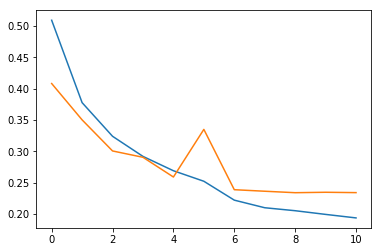

In [19]:
#print (hist.history)
from matplotlib import pyplot as plt
%matplotlib inline
plt.figure(1)
plt.plot (hist.history['loss'])
plt.plot (hist.history['val_loss'])

## Load the model

In [20]:
from keras.models import load_model
model = load_model('my_model2.h5')

## predict the test data

In [21]:
y_pred = model.predict([X1_test, X2_test], batch_size=1024)

In [22]:
# To make a submission file 
def make_submission(predict_prob):
    with open('sub2.csv', 'w') as file:
        file.write(str('y_pre') + '\n')
        for line in predict_prob:
            #line = np.clip(line, 0.005, 0.995)
            file.write(str(line[0]) + '\n')
    file.close()
    
make_submission(y_pred)